# Lab 3: Valutazione delle definizioni (Content-to-Form)

## Obiettivo
Implementare un sistema di ricerca onomasiologica che, partendo da definizioni testuali, identifica il synset corretto in WordNet.

La ricerca onomasiologica è un processo inverso rispetto alla consultazione tradizionale di un dizionario:
- **Approccio tradizionale (forma → contenuto)**: data una parola, trovare il suo significato
- **Approccio onomasiologico (contenuto → forma)**: data una definizione/descrizione, trovare il termine/synset corrispondente

## Contesto
Dopo aver prodotto e analizzato definizioni per diversi concetti nel Lab 2, ora verificheremo se e quanto le definizioni prodotte siano sufficientemente informative e ben strutturate da permettere l'identificazione del synset corretto in WordNet.

## Setup iniziale

Importiamo le librerie necessarie e i moduli custom.

In [16]:
# Import librerie standard
import nltk
from nltk.corpus import wordnet as wn
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Optional, Tuple

import src.utils as utils

 
# Configurazione visualizzazioni
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Assicurarsi che WordNet sia disponibile
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

print("Setup completato!")

Setup completato!


In [17]:
# Import moduli custom
from importlib import reload
import sys
sys.path.append('.')

import src.content_to_form as ctf
import src.evaluation as evaluation
import src.wordnet_helpers as wnh

# Reload per sviluppo
reload(ctf)
reload(evaluation)
reload(wnh)

print("Moduli custom importati con successo!")

Moduli custom importati con successo!


## 1. Caricamento delle definizioni

Carichiamo le definizioni prodotte nel Lab 2.

In [18]:
# Caricare dataset definizioni
definitions_df = pd.read_csv("data/dataset_definizioni_Lab2.csv", sep=';')

# Il dataset ha una struttura particolare: ogni colonna è un concetto,
# ogni riga è una definizione diversa per quel concetto
print(f"Shape del dataset: {definitions_df.shape}")
print(f"\nConcetti nel dataset: {list(definitions_df.columns)}")
print(f"\nPrime definizioni per ogni concetto:")
definitions_df.head()

Shape del dataset: (39, 4)

Concetti nel dataset: ['Pantalone', 'Microscopio', 'Pericolo', 'Euristica']

Prime definizioni per ogni concetto:


,Pantalone,Microscopio,Pericolo,Euristica
0,indumento (detto anche calzoni) maschile e fe...,Strumento che permette di ottenere immagini in...,Circostanza o complesso di circostanze da cui ...,Aspetto del metodo scientifico che comprende u...
1,Indumento che si indossa sulla parte inferiore...,Strumento scientifico atto a osservare il mond...,Situazione o Evento che può mettere a rischio ...,Metodo matematico e statistico per risolvere u...
2,Indumento per la parte inferiore del corpo umano,Strumento scientifico per l'osservazione di mi...,Situazione potenzialmente rischiosa,Strategia di ricerca nello spazio degli stati
3,"Indumento per le gambe, diviso per ogni gamba ...",Dispositivo ottico o elettronico per ispeziona...,Situazione in cui si teme per la propria o alt...,Strategia di ricerca che permette di stimare i...
4,abito indossato sulle gambe,strumento dotato di lenti che permette di visu...,condizione che può causare danni alle persone ...,regola che permette di approssimare una soluzi...


## Implementazione ricerca onomasiologica


### UPDATE
I primi tentativi di implementazione della ricerca onomasiologica sono stati completati ma con scarsi risultati. Per questo motivo ho deciso di provare un approccio più di reverse engineering, cercando di capire come ottimizzare la ricerca onomasiologica partendo dalle definizioni stesse.

Di seguito, mostro i passaggi che ho seguito per ottimizzare la ricerca onomasiologica, partendo dalle definizioni e arrivando alla ricerca dei synset in WordNet.

### A. Analisi dell'algoritmo di similarità.
Partendo da una definizione di microscopio presa dal vocabolario (in inglese), testo la similarità tra il synset di microscopio e i synset ottenuti dai precedenti tentativi di ricerca onomasiologica:

In [19]:
from nltk.corpus import stopwords
from importlib import reload
import src.content_to_form as ctf
from nltk.corpus import wordnet as wn

reload(ctf)
definition = "a device that uses lenses to make very small objects look larger, so that they can be scientifically examined and studied"
stop_words = set(stopwords.words('english'))
tokens = wnh.old_extract_keywords(definition, stop_words)
print(f"Tokens after preprocessing: {tokens}")

candidates = [
    "microscope.n.01",
    "lens.n.01",
    "stroboscope.n.01",
    "device.n.01",
    "lift.n.06",
    "fresnel_lens.n.01",
]      

ranked = ctf.rank_synsets_by_similarity(tokens, candidates, similarity_method="jaccard")
print("Ranked Synsets by Similarity (Jaccard):")
for synset, score in ranked:
    print(f"{synset.name()}: {score:.4f}")
    
print ("\n" + "="*80 + "\n")
ranked = ctf.rank_synsets_by_similarity(tokens, candidates, similarity_method="cosine")
print("Ranked Synsets by Similarity (Cosine):")
for synset, score in ranked:
    print(f"{synset.name()}: {score:.4f}")
print ("\n" + "="*80 + "\n")
    

Tokens after preprocessing: ['device', 'us', 'lens', 'make', 'small', 'object', 'look', 'larger', 'scientifically', 'examined', 'studied']
Ranked Synsets by Similarity (Jaccard):
stroboscope.n.01: 0.2069
microscope.n.01: 0.1944
fresnel_lens.n.01: 0.1515
lens.n.01: 0.1200
lift.n.06: 0.1200
device.n.01: 0.0714


Ranked Synsets by Similarity (Cosine):
microscope.n.01: 0.3731
stroboscope.n.01: 0.3693
fresnel_lens.n.01: 0.2901
lens.n.01: 0.2194
lift.n.06: 0.2194
device.n.01: 0.1383




Come si può vedere, i primi problemi nascono già a livello di calcolo della similarità:
Ci sono termini che sono molto vicini alla definizione, addirittura più vicini della parola corretta.
Questo è un problema che si presenterà spesso e va tenuto conto. 
Anche quando si ottiene la parola corretta, la distanza dalle altre parole è molto bassa.
Nel risultato finale (quello mostrato in precedenza) non è particolarmente problematico in quanto i termini vicini hanno comunque una certa attinenza con la definizione.

QUesto risultato è stato ottenuto con un affinamento del processo di estrazione dei token dalle definizioni del senso dal wordnet. Non è possibile dare una risposta definitiva su quale sia la variante migliore, ma è possibile fare alcune considerazioni sul risultato che questo è il migliore ottenuto con il synset `microscope.n.01` come target.
In questo caso, la variante più efficace di definizione si è dimostrata quella che include tutto:
-  lemmi,
-  gloss,
-  esempi,
-  domini
-  termini provenienti da relazioni (iperonimi, meronimi, similar_tos, ecc.)

Di seguito i token estratti dal synset di `microscope.n.01`:

In [20]:
synset = wn.synset("microscope.n.01")
st= wnh.synset_to_tokens(synset, stop_words=set(stopwords.words('english')), include_relations=True, rel_depth=1)
print(f"Tokens extracted from synset 'microscope.n.01': {st}")

Tokens extracted from synset 'microscope.n.01': ['microscope', 'magnifier', 'image', 'small', 'object', 'invention', 'microscope', 'led', 'discovery', 'cell', 'magnifier', 'camera', 'lucida', 'scientific', 'instrument', 'magnifies', 'image', 'optical', 'device', 'consisting', 'attachment', 'enables', 'observer', 'view', 'simultaneously', 'image', 'drawing', 'surface', 'sketching', 'scientifically', 'study', 'studied', 'examine', 'examined', 'device', 'use', 'look']


### B. Implementazione della ricerca onomasiologica di Test
Proseguo implementando la ricerca onomasiologica guidata: il test sarà sempre la parola microscopio, ma questa volta cercerò di raggiungerla partendo effettivamente dalla definizione.

Inizialmente era stato implementato un algoritmo di ricerca onomasiologica che si basava su una ricerca a profondità limitata nei synset collegati ai synset candidati, con alcuni sistemi di ottimizzazione come troncare via i synset al di sotto di una certa soglia di similarità con la definizione. Tuttavia questo approccio si è rivelato inefficace, in quanto per raggiungere il synset di microscopio era necessario passare per alcuni synset che avevano una similarità *molto bassa* con la definizione, e quindi venivano scartati.

L'algoritmo finale quindi risulta più pesante, ma porta a risultati decisamente migliori:
Sono state rimosse tutte le ottimizzazioni che scartavano i synset a bassa similarità.
Si effettua ora una ricerca e raccolta di tutti i synset che sono iperonomi dei synset candidati, per poi effettuare un ranking di tutti i synset raccolti.

Non è ancora formalmente dimostrato che il seguente algoritmo termini per conclusione dei synset validi.
La sua terminazione dipende principalmente dalla struttura di Wordnet stesso e dall'assunto che dopo un tot di passaggi (circa 20), l'algoritmo non trova più iperonimi non visitati.
Questa incertezza di non terminazione è però limitata da `deep_search` che lo limita a un numero massimo di iterazioni per evitare loop infiniti. Tale comportamento mi risulta un compromesso accettabile, in quanto non ho alcun modo per sapere a priori se ho già raggiunto il synset corretto (anche perchè spesso, per definizioni più corte e generiche, capiterà di trovare dei synset che presentano una similarità maggiore del goal o che il goal si trovi molto lontano dalle parole usate).

In virtù della seguente analisi, ho ritenuto accettabile una ricerca quanto più approfondita sui synset raggiungibile con un limite massimo di controllo sulla ricerca e sperare che il synset sia tra quelli raggiunti: Se il goal è troppo lontano dalla definizione sarebbe comunque troppo esoso da raggiungere e vorrebbe dire che la definizione è cosi generica che verrebbero trovate comunque molte parole più vicine alla definizione ma lontane dal goal.

In [21]:
from nltk.corpus import stopwords
from importlib import reload
import src.content_to_form as ctf
from nltk.corpus import wordnet as wn

reload(ctf)
definition = "a device that uses lenses to make very small objects look larger, so that they can be scientifically examined and studied"
stop_words = set(stopwords.words('english'))
tokens = wnh.old_extract_keywords(definition, stop_words)
print(f"Tokens after preprocessing: {tokens}")


# Cercare synset candidati usando il sistema content-to-form (aumentare a 30 candidati)
candidates_en = ctf.search_synset_from_definition(
    definition,
    max_results=200,
    DEBUG=0,
    deep_search=6,
    similarity_method="jaccard",
    extract_method="old",
)

c=10

print(f"Top {c} synset candidati (Jaccard Similarity):\n")
for i, (synset, score) in enumerate(candidates_en[:c], 1):
    print(f"{i}. {synset.name()} (score: {score:.3f})")
    print(f"   Definizione: {synset.definition()}")
    print(f"   Lemmi: {', '.join([l.name() for l in synset.lemmas()][:5])}")
    if synset.hypernyms():
        print(f"   Iperonimo: {synset.hypernyms()[0].name()}")
    print()


Tokens after preprocessing: ['device', 'us', 'lens', 'make', 'small', 'object', 'look', 'larger', 'scientifically', 'examined', 'studied']
Top 10 synset candidati (Jaccard Similarity):

1. stroboscope.n.01 (score: 0.207)
   Definizione: scientific instrument that provides a flashing light synchronized with the periodic movement of an object; can make moving object appear stationary
   Lemmi: stroboscope, strobe, strobe_light
   Iperonimo: scientific_instrument.n.01

2. light_microscope.n.01 (score: 0.200)
   Definizione: microscope consisting of an optical instrument that magnifies the image of an object
   Lemmi: light_microscope
   Iperonimo: microscope.n.01

3. microscope.n.01 (score: 0.194)
   Definizione: magnifier of the image of small objects
   Lemmi: microscope
   Iperonimo: magnifier.n.01

4. tachistoscope.n.01 (score: 0.192)
   Definizione: scientific instrument used by psychologists; presents visual stimuli for brief exposures
   Lemmi: tachistoscope, t-scope
   Iperonimo: 

In [22]:
from nltk.corpus import stopwords
from importlib import reload
import src.content_to_form as ctf
from nltk.corpus import wordnet as wn

reload(ctf)
definition = "a device that uses lenses to make very small objects look larger, so that they can be scientifically examined and studied"
stop_words = set(stopwords.words('english'))
tokens = wnh.old_extract_keywords(definition, stop_words)
print(f"Tokens after preprocessing: {tokens}")

# Cercare synset candidati usando il sistema content-to-form (aumentare a 30 candidati)
candidates_en = ctf.search_synset_from_definition(
    definition,
    max_results=200,
    DEBUG=0,
    deep_search=6,
    similarity_method="cosine",
    extract_method="old",
)

c=5

print(f"Top {c} synset candidati (Cosine Similarity):\n")
for i, (synset, score) in enumerate(candidates_en[:c], 1):
    print(f"{i}. {synset.name()} (score: {score:.3f})")
    print(f"   Definizione: {synset.definition()}")
    print(f"   Lemmi: {', '.join([l.name() for l in synset.lemmas()][:5])}")
    if synset.hypernyms():
        print(f"   Iperonimo: {synset.hypernyms()[0].name()}")
    print()


Tokens after preprocessing: ['device', 'us', 'lens', 'make', 'small', 'object', 'look', 'larger', 'scientifically', 'examined', 'studied']


Top 5 synset candidati (Cosine Similarity):

1. microscope.n.01 (score: 0.373)
   Definizione: magnifier of the image of small objects
   Lemmi: microscope
   Iperonimo: magnifier.n.01

2. stroboscope.n.01 (score: 0.369)
   Definizione: scientific instrument that provides a flashing light synchronized with the periodic movement of an object; can make moving object appear stationary
   Lemmi: stroboscope, strobe, strobe_light
   Iperonimo: scientific_instrument.n.01

3. light_microscope.n.01 (score: 0.346)
   Definizione: microscope consisting of an optical instrument that magnifies the image of an object
   Lemmi: light_microscope
   Iperonimo: microscope.n.01

4. tachistoscope.n.01 (score: 0.337)
   Definizione: scientific instrument used by psychologists; presents visual stimuli for brief exposures
   Lemmi: tachistoscope, t-scope
   Iperonimo: scientific_instrument.n.01

5. ultramicroscope.n.01 (score: 0.329)
   Definizione: light microscope that uses scattered light to show particl

### Elefante nella stanza: l'Italiano

Finora ho lavorato esclusivamente con WordNet in Inglese, e le definizioni prodotte sono in Inglese.
Questo è un limite importante, in quanto il vocabolario di partenza è in Italiano, e quindi le definizioni prodotte sono in Italiano.




In [23]:
from nltk.corpus import stopwords
from importlib import reload
import src.content_to_form as ctf
import src.wordnet_helpers as wnh
from nltk.corpus import wordnet as wn

reload(wnh)
reload(ctf)
definition = "Strumento che permette di ottenere immagini ingrandite di oggetti molto piccoli rivelando dettagli altrimenti invisibili."
english_tokens = wnh.translate_tokens(definition, lang='ita', DEBUG=0)
print(f"Tokens after preprocessing: {tokens}")
print (f"English Tokens after translation: {english_tokens}")

candidates = [
    "microscope.n.01",
    "receive.v.02",
    "fence.v.02",
    "periscope.n.01",
    
]      

print ("\n" + "="*80 + "\n")
ranked = ctf.rank_synsets_by_similarity(english_tokens, candidates, similarity_method="jaccard", lang='ita', DEBUG=0)
print("Ranked Synsets by Similarity (Jaccard):")
for synset, score in ranked:
    print(f"{synset.name()}: {score:.4f}")
    
print ("\n" + "="*80 + "\n")
ranked = ctf.rank_synsets_by_similarity(english_tokens, candidates, similarity_method="cosine", lang='ita', DEBUG=0)
print("Ranked Synsets by Similarity (Cosine):")
for synset, score in ranked:
    print(f"{synset.name()}: {score:.4f}")
print ("\n" + "="*80 + "\n")

print(f"synsets  di invisibile: {wn.synsets('invisibile', lang='ita')}")

    

Tokens after preprocessing: ['device', 'us', 'lens', 'make', 'small', 'object', 'look', 'larger', 'scientifically', 'examined', 'studied']
English Tokens after translation: ['instrument', 'let', 'get', 'image', 'elaborate', 'object', 'small', 'unwrap', 'detail', 'invisible']


Ranked Synsets by Similarity (Jaccard):
microscope.n.01: 0.1053
fence.v.02: 0.0588
periscope.n.01: 0.0435
receive.v.02: 0.0263


Ranked Synsets by Similarity (Cosine):
microscope.n.01: 0.2236
fence.v.02: 0.1118
periscope.n.01: 0.0845
receive.v.02: 0.0587


synsets  di invisibile: []


E siamo arrivati a un punto di rottura: la ricerca onomasiologica in Italiano è decisamente più complessa, in quanto WordNet in Italiano è molto meno ricco di relazioni e definizioni rispetto a quello in Inglese.

Già in fase di estrazione dei token dalla definizione, i synset candidati spesso erano lemmi non riconosciuti dallo stesso WordNet, in quanto il synset è mappato con il maschile, singolare, etc, mentre le definizioni ottenuti non rispettavano questa forma. (`wnh.old_extract_keywords`)

Il problema è stato parzialmente risolto passando a SpaCY. Con SpaCY è stato possibile estrarre lemmi più vicini a quelli presenti in WordNet, e quindi ottenere dei synset candidati più vicini alla definizione. Tuttavia, anche con questo approccio, i risultati sono stati decisamente inferiori rispetto a quelli ottenuti con WordNet in Inglese.

Il motivo è che alcuni token (anche chiave per la definizione) non sono presenti in WordNet in Italiano.
Un esempio critico sono: ingrandito, invisibile, rivelira.

Si applica un workaround: i token estratti dalla definizione in Italiano non riconosciuti,  vengono tradotti manualmente in Inglese, e poi si procede con la ricerca onomasiologica in Inglese.

Tutta questa serie di ottimizzazioni e workaround hanno permesso all'esempio di funzionare:

In [24]:
from nltk.corpus import stopwords
from importlib import reload
import src.content_to_form as ctf
import src.wordnet_helpers as wnh
from nltk.corpus import wordnet as wn

reload(wnh)
reload(ctf)
definition = "Strumento che permette di ottenere immagini ingrandite di oggetti molto piccoli rivelando dettagli altrimenti invisibili."
print (f"Definizione: {definition}")
stop_words = set(stopwords.words('italian'))
tokens = wnh.translate_tokens(
    sentence=definition,
    lang='ita', 
    DEBUG=0
)
print(f"Tokens after preprocessing: {tokens}")

candidates = [
    "microscope.n.01",
    "receive.v.02",
    "fence.v.02",
    "periscope.n.01",
    
]      

print ("\n" + "="*80 + "\n")
ranked = ctf.rank_synsets_by_similarity(tokens, candidates, similarity_method="jaccard", lang='eng', DEBUG=0)
print("Ranked Synsets by Similarity (Jaccard):")
for synset, score in ranked:
    print(f"{synset.name()}: {score:.4f}")
    
print ("\n" + "="*80 + "\n")
ranked = ctf.rank_synsets_by_similarity(tokens, candidates, similarity_method="cosine", lang='eng', DEBUG=0)
print("Ranked Synsets by Similarity (Cosine):")
for synset, score in ranked:
    print(f"{synset.name()}: {score:.4f}")
print ("\n" + "="*80 + "\n")
    

Definizione: Strumento che permette di ottenere immagini ingrandite di oggetti molto piccoli rivelando dettagli altrimenti invisibili.
Tokens after preprocessing: ['instrument', 'let', 'get', 'image', 'elaborate', 'object', 'small', 'unwrap', 'detail', 'invisible']


Ranked Synsets by Similarity (Jaccard):
microscope.n.01: 0.1053
fence.v.02: 0.0588
periscope.n.01: 0.0435
receive.v.02: 0.0263


Ranked Synsets by Similarity (Cosine):
microscope.n.01: 0.2236
fence.v.02: 0.1118
periscope.n.01: 0.0845
receive.v.02: 0.0587




In [25]:
from importlib import reload
import src.content_to_form as ctf
import src.wordnet_helpers as wnh
from nltk.corpus import wordnet as wn

reload(ctf)
reload(wnh)
definition = "Strumento che permette di ottenere immagini ingrandite di oggetti molto piccoli rivelando dettagli altrimenti invisibili."
print (f"Definizione: {definition}")


# Cercare synset candidati usando il sistema content-to-form (aumentare a 30 candidati)
candidates_en = ctf.search_synset_from_definition(
    definition,
    lang='ita',
    max_results=10,
    DEBUG=0,
    deep_search=6,
    similarity_method="cosine",
)

c=10

print(f"Top {c} synset candidati (Cosine Similarity):\n")
for i, (synset, score) in enumerate(candidates_en[:c], 1):
    print(f"{i}. {synset.name()} (score: {score:.3f})")
    print(f"   Definizione: {synset.definition()}")
    print(f"   Lemmi: {', '.join([l.name() for l in synset.lemmas()][:5])}")
    if synset.hypernyms():
        print(f"   Iperonimo: {synset.hypernyms()[0].name()}")
    print()


Definizione: Strumento che permette di ottenere immagini ingrandite di oggetti molto piccoli rivelando dettagli altrimenti invisibili.


Top 10 synset candidati (Cosine Similarity):

1. light_microscope.n.01 (score: 0.290)
   Definizione: microscope consisting of an optical instrument that magnifies the image of an object
   Lemmi: light_microscope
   Iperonimo: microscope.n.01

2. angioscope.n.01 (score: 0.286)
   Definizione: a modified microscope used to study capillary vessels
   Lemmi: angioscope
   Iperonimo: microscope.n.01

3. ultramicroscope.n.01 (score: 0.276)
   Definizione: light microscope that uses scattered light to show particles too small to see with ordinary microscopes
   Lemmi: ultramicroscope, dark-field_microscope
   Iperonimo: light_microscope.n.01

4. binocular_microscope.n.01 (score: 0.254)
   Definizione: a light microscope adapted to the use of both eyes
   Lemmi: binocular_microscope
   Iperonimo: light_microscope.n.01

5. collimator.n.01 (score: 0.245)
   Definizione: a small telescope attached to a large telescope to use in setting the line of the larger one
   Lemmi: collimator
   Iperonim

## Applicazione

Procediamo ora ad applicare la ricerca onomasiologica a tutte le definizioni prodotte, e a valutare i risultati ottenuti.

In [26]:
# Caricare dataset definizioni (se non gia presente)
if 'definitions_df' not in globals():
    definitions_df = pd.read_csv("data/dataset_definizioni_Lab2.csv", sep=';')

# Trasformare il dataset wide in formato long (concetto, definizione)
data_long = []
concept_definitions = {}
for concept in definitions_df.columns:
    definitions = []
    for definition in definitions_df[concept].dropna():
        definition = str(definition).strip()
        if definition:
            data_long.append({"concept": concept, "definition": definition})
            definitions.append(definition)
    concept_definitions[concept] = definitions

df = pd.DataFrame(data_long)

print(f"Shape del dataset long: {df.shape}")
print(f"Concetti nel dataset: {list(concept_definitions.keys())}")
print(f"Definizioni per concetto:")
for concept, defs in concept_definitions.items():
    print(f"- {concept}: {len(defs)}")

# Mappa concetto -> synset gold (fallback su mappature manuali)
manual_gold_map = {
    "Pantalone": ["trouser.n.01", "pants.n.01", "pant.n.01"],
    "Microscopio": ["microscope.n.01"],
    "Pericolo": ["danger.n.01", "peril.n.01"],
    "Euristica": ["heuristic.n.01"],
}

def resolve_gold_synset(concept_name: str) -> Optional[str]:
    """Restituisce un synset gold per il concetto, se disponibile."""
    # Prova WordNet italiano
    ita_synsets = wn.synsets(concept_name, lang='ita')
    if ita_synsets:
        return ita_synsets[0].name()
    # Prova mappatura manuale
    for syn_name in manual_gold_map.get(concept_name, []):
        try:
            wn.synset(syn_name)
            return syn_name
        except Exception:
            continue
    # Fallback: traduci il concetto e prova con WordNet inglese
    translated = wnh.translate_tokens(concept_name, lang='ita', DEBUG=0)
    for tok in translated:
        syns = wn.synsets(tok, pos='n', lang='eng')
        if syns:
            return syns[0].name()
    return None

concept_to_synsets = {}
for concept in concept_definitions.keys():
    gold = resolve_gold_synset(concept)
    concept_to_synsets[concept] = [gold] if gold else []

print("\nGold synset (se disponibile):")
for concept, syns in concept_to_synsets.items():
    print(f"- {concept}: {syns[0] if syns else 'N/A'}")

Shape del dataset long: (156, 2)
Concetti nel dataset: ['Pantalone', 'Microscopio', 'Pericolo', 'Euristica']
Definizioni per concetto:
- Pantalone: 39
- Microscopio: 39
- Pericolo: 39
- Euristica: 39

Gold synset (se disponibile):
- Pantalone: trouser.n.01
- Microscopio: microscope.n.01
- Pericolo: risk.n.02
- Euristica: heuristic.n.01


In [27]:
# Ricerca onomasiologica per tutte le definizioni con fallback
def search_with_fallback(definition: str, max_results: int = 10) -> List[Tuple]:
    """Cerca synset con fallback da ITA -> ENG se necessario."""
    # Prima prova in italiano
    candidates = ctf.search_synset_from_definition(
        definition,
        lang='ita',
        max_results=10,
        DEBUG=0,
        deep_search=6,
        similarity_method="cosine",
    )
    if candidates:
        return candidates
    # Fallback: traduci i token e cerca in inglese
    translated_tokens = wnh.translate_tokens(definition, lang='ita', DEBUG=0)
    if not translated_tokens:
        return []
    candidate_synsets = []
    seen = set()
    for tok in translated_tokens:
        for synset in wn.synsets(tok, lang='eng'):
            if synset.name() not in seen:
                seen.add(synset.name())
                candidate_synsets.append(synset.name())
    if not candidate_synsets:
        return []
    ranked = ctf.rank_synsets_by_similarity(
        translated_tokens,
        candidate_synsets,
        similarity_method="jaccard",
        lang="eng",
        DEBUG=0,
    )
    return ranked[:max_results]

results_by_concept = {}
for concept, definitions in concept_definitions.items():
    concept_results = []
    for definition in definitions:
        candidates = search_with_fallback(definition, max_results=10)
        concept_results.append({
            "definition": definition,
            "candidates": candidates,
        })
    results_by_concept[concept] = concept_results

print("Ricerca completata.")
for concept, items in results_by_concept.items():
    print(f"- {concept}: {len(items)} definizioni")

Ricerca completata.
- Pantalone: 39 definizioni
- Microscopio: 39 definizioni
- Pericolo: 39 definizioni
- Euristica: 39 definizioni


In [28]:
# Tabella riassuntiva per concetto
summary_rows = []
for concept, items in results_by_concept.items():
    gold_list = concept_to_synsets.get(concept, [])
    gold_synset = None
    if gold_list:
        try:
            gold_synset = wn.synset(gold_list[0])
        except Exception:
            gold_synset = None

    perfect = 0
    top10 = 0
    miss = 0
    for item in items:
        preds = [syn for syn, _ in item["candidates"]]
        rank = evaluation.find_rank_of_correct(preds, gold_synset)
        if rank is None:
            miss += 1
        elif rank == 1:
            perfect += 1
        elif rank <= 10:
            top10 += 1
        else:
            miss += 1
    summary_rows.append({
        "concept": concept,
        "perfect_top1": perfect,
        "success_top10": top10,
        "failures": miss,
    })

summary_df = pd.DataFrame(summary_rows).sort_values(by="concept")
summary_df

,concept,perfect_top1,success_top10,failures
3,Euristica,0,1,38
1,Microscopio,0,6,33
0,Pantalone,0,0,39
2,Pericolo,0,0,39


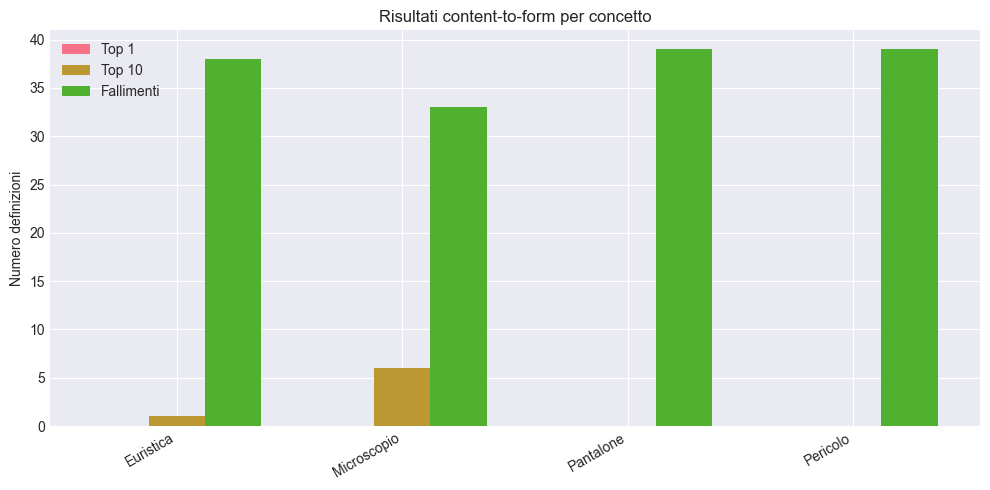

In [29]:
# Grafico: performance per concetto
if 'summary_df' in globals() and not summary_df.empty:
    plt.figure(figsize=(10, 5))
    x = np.arange(len(summary_df))
    width = 0.25

    plt.bar(x - width, summary_df['perfect_top1'], width, label='Top 1')
    plt.bar(x, summary_df['success_top10'], width, label='Top 10')
    plt.bar(x + width, summary_df['failures'], width, label='Fallimenti')

    plt.xticks(x, summary_df['concept'], rotation=30, ha='right')
    plt.ylabel('Numero definizioni')
    plt.title('Risultati content-to-form per concetto')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("summary_df non disponibile o vuoto.")

---
---

In [30]:
# Salva i risultati di ricerca onomasiologica in CSV (compatto + flattened)
import json
from typing import Any

rows = []
flat_rows = []
for concept, items in results_by_concept.items():
    gold = concept_to_synsets.get(concept, [None])[0] if concept_to_synsets.get(concept) else None
    for item in items:
        definition = item["definition"]
        candidates = item.get("candidates", [])

        cand_list = []
        for rank, cand in enumerate(candidates, start=1):
            # cand can be a tuple (synset, score) or a synset name string
            if isinstance(cand, (list, tuple)):
                syn, score = cand
            else:
                syn, score = cand, None

            # Normalize synset representation to a name string
            try:
                syn_name = syn.name() if hasattr(syn, "name") else str(syn)
            except Exception:
                syn_name = str(syn)

            cand_entry = {"rank": rank, "synset": syn_name, "score": score}
            cand_list.append(cand_entry)

            # Flattened row per candidate
            flat_rows.append({
                "concept": concept,
                "definition": definition,
                "gold_synset": gold,
                "rank": rank,
                "candidate_synset": syn_name,
                "score": score,
            })

        rows.append({
            "concept": concept,
            "definition": definition,
            "gold_synset": gold,
            "candidates": json.dumps(cand_list, ensure_ascii=False),
            "n_candidates": len(cand_list),
        })

# DataFrame compatto (candidates serializzati)
out_df = pd.DataFrame(rows)
out_path = "outputs/content_to_form_results.csv"
out_df.to_csv(out_path, index=False)

# DataFrame flattened (una riga per candidato)
flat_df = pd.DataFrame(flat_rows)
flat_path = "outputs/content_to_form_results_flat.csv"
flat_df.to_csv(flat_path, index=False)

print(f"Saved {len(out_df)} concept-definition rows to {out_path}")
print(f"Saved {len(flat_df)} candidate rows to {flat_path}")

# Mostra anteprima
display(out_df.head())
display(flat_df.head())

Saved 156 concept-definition rows to outputs/content_to_form_results.csv
Saved 1553 candidate rows to outputs/content_to_form_results_flat.csv


,concept,definition,gold_synset,candidates,n_candidates
0,Pantalone,indumento (detto anche calzoni) maschile e fem...,trouser.n.01,"[{""rank"": 1, ""synset"": ""spat.n.02"", ""score"": 0...",10
1,Pantalone,Indumento che si indossa sulla parte inferiore...,trouser.n.01,"[{""rank"": 1, ""synset"": ""body_stocking.n.01"", ""...",10
2,Pantalone,Indumento per la parte inferiore del corpo umano,trouser.n.01,"[{""rank"": 1, ""synset"": ""straitjacket.n.02"", ""s...",10
3,Pantalone,"Indumento per le gambe, diviso per ogni gamba ...",trouser.n.01,"[{""rank"": 1, ""synset"": ""camlet.n.01"", ""score"":...",10
4,Pantalone,abito indossato sulle gambe,trouser.n.01,"[{""rank"": 1, ""synset"": ""bonnet.v.01"", ""score"":...",10


,concept,definition,gold_synset,rank,candidate_synset,score
0,Pantalone,indumento (detto anche calzoni) maschile e fem...,trouser.n.01,1,spat.n.02,0.245256
1,Pantalone,indumento (detto anche calzoni) maschile e fem...,trouser.n.01,2,scout.n.02,0.229416
2,Pantalone,indumento (detto anche calzoni) maschile e fem...,trouser.n.01,3,pant_leg.n.01,0.217643
3,Pantalone,indumento (detto anche calzoni) maschile e fem...,trouser.n.01,4,legging.n.01,0.207514
4,Pantalone,indumento (detto anche calzoni) maschile e fem...,trouser.n.01,5,lockstep.n.02,0.191346
